In [1]:
!nvidia-smi

Tue Jul 20 15:32:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Installing dependencies

In [2]:
!pip install transformers
!pip install text_hammer 

     |████████████████████████████████| 115 kB 391 kB/s 
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.9.3
    Uninstalling beautifulsoup4-4.9.3:
      Successfully uninstalled beautifulsoup4-4.9.3


# Importing libraries

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import text_hammer as th


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy,BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy,BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

# Importing data

In [4]:
train=pd.read_csv('../input/nlp-getting-started/train.csv')
test=pd.read_csv('../input/nlp-getting-started/test.csv')

In [5]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
train.shape

(7613, 5)

In [7]:
test.shape

(3263, 4)

In [8]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
train=train.fillna(" ")

In [10]:
train.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [11]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='target', ylabel='count'>

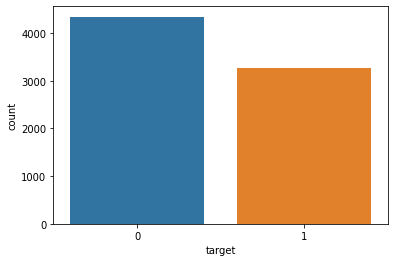

In [12]:
sns.countplot(train.target)

In [13]:
# drop duplicate values
train=train.drop_duplicates('text',keep='last')

In [14]:
train.shape

(7503, 5)

<AxesSubplot:xlabel='count', ylabel='keyword'>

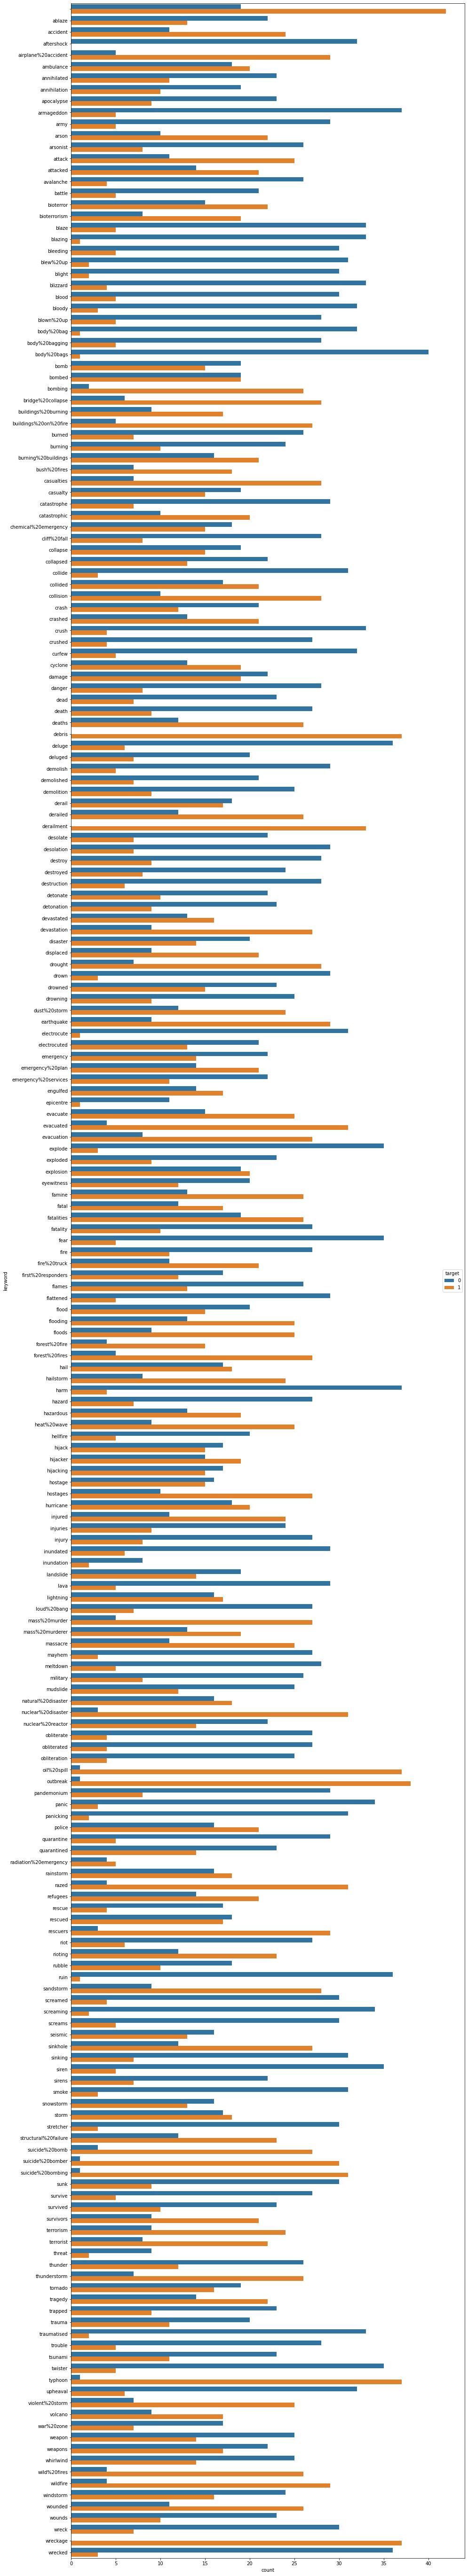

In [15]:
plt.figure(figsize=(15,100))
sns.countplot(data=train, y='keyword' , hue='target')

# Text Preprocessing

In [16]:
def preprocess(text):
  text=str(text).lower()
  text=th.remove_urls(text)
  text=th.cont_exp(text)
  text=th.remove_emails(text)
  text=th.remove_html_tags(text)
  text=th.remove_special_chars(text)
  text=th.remove_accented_chars(text)
  text = str(text).lower().replace('\\', '').replace('_', ' ')
  return text

In [17]:
# train prerocessing
train.text=train.text.apply(preprocess)
train.keyword=train.keyword.apply(preprocess)

In [18]:
# test preprocessing
test.text=test.text.apply(preprocess)

In [19]:
# train.text=train.text+" "+train.keyword

In [20]:
y_train = train.target.values

In [21]:
train.text[0]

'our deeds are the reason of this earthquake may allah forgive us all'

In [22]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-large-uncased')
bert = TFBertModel.from_pretrained('bert-large-uncased')

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.47G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-large-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-large-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [23]:
tokenizer(train.text[5])

{'input_ids': [101, 6857, 10273, 10651, 2662, 1044, 18418, 2322, 2701, 1999, 2119, 7826, 2349, 2000, 2697, 2221, 2543, 24689, 7442, 3748, 26332, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [24]:
train.text[1]

'forest fire near la ronge sask canada'

In [25]:
print("max len of tweets",max([len(x.split()) for x in train.text]))
max_length = 40

max len of tweets 35


In [26]:
x_train = tokenizer(
    text=train.text.tolist(),
    add_special_tokens=True,
    max_length=40,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [27]:
x_train['input_ids'].shape

TensorShape([7503, 40])

# MODEL

In [28]:
max_len = 40


input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")


embeddings = bert(input_ids,attention_mask = input_mask)[1]
out=tf.keras.layers.Dropout(0.07)(embeddings)
out = Dense(128, activation='relu')(embeddings)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(32,activation = 'relu')(out)

y = Dense(1,activation = 'sigmoid')(out)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 40)]         0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 335141888   input_ids[0][0]                  
                                                                 attention_mask[0][0]             
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          131200      tf_bert_model[0][1]          

In [30]:
optimizer = Adam(
    learning_rate=3e-5,
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)

# Set loss and metrics
loss = BinaryCrossentropy(from_logits = True)
metric = BinaryAccuracy('accuracy'),

# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

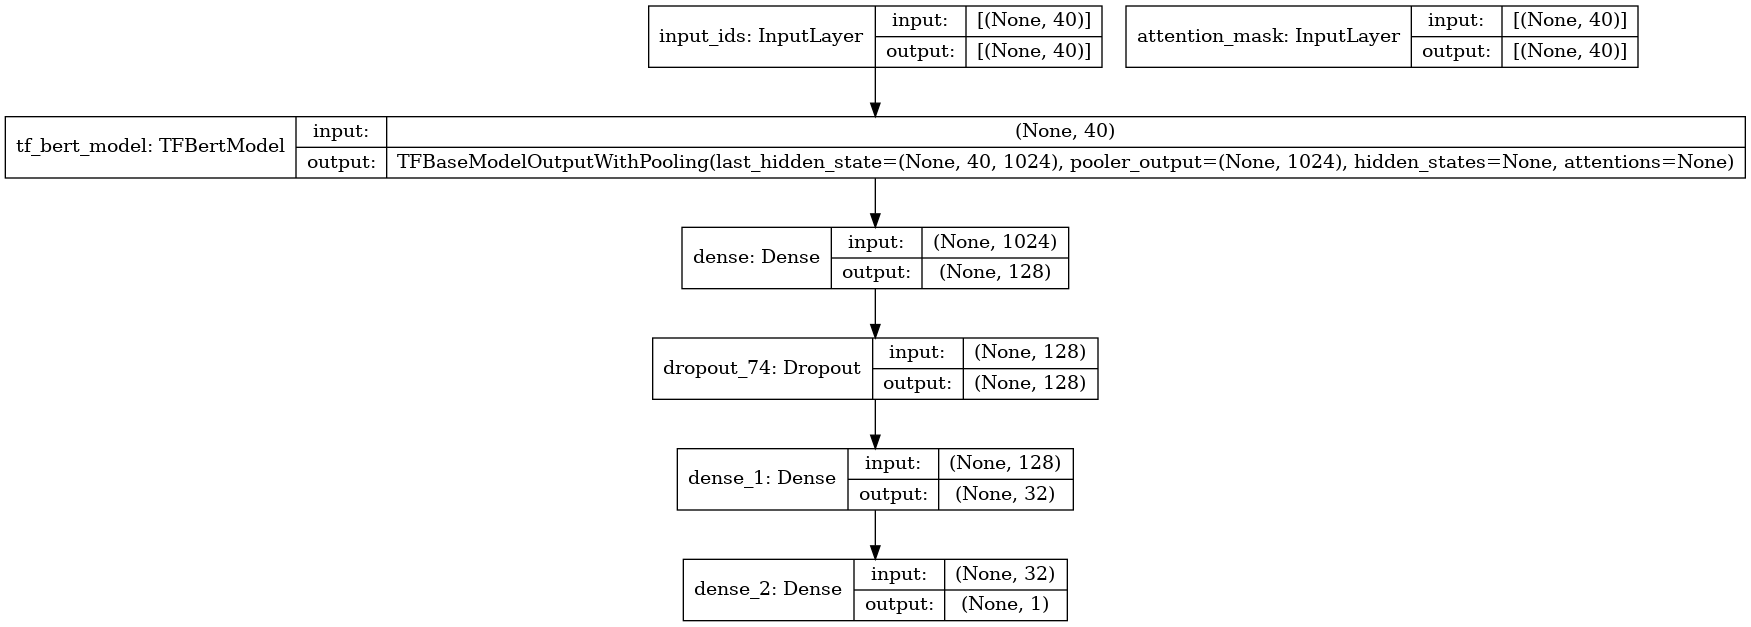

In [31]:
plot_model(model, show_shapes = True)

In [32]:
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Model training

In [33]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
  epochs=2,
    batch_size=32
)

Epoch 1/2
235/235 [==============================] - 162s 519ms/step - loss: 0.5223 - accuracy: 0.7516
Epoch 2/2
235/235 [==============================] - 122s 518ms/step - loss: 0.3287 - accuracy: 0.8740


In [34]:
test = tokenizer(
    text=test.text.tolist(),
    add_special_tokens=True,
    max_length=40,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

# Prediction

In [35]:
pred = model.predict({'input_ids':test['input_ids'],'attention_mask':test['attention_mask']}) 

In [36]:
y_predicted = np.where(pred>0.5,1,0)

In [37]:
y_predicted = y_predicted.reshape((1,3263))[0]
y_predicted

array([1, 1, 1, ..., 1, 1, 1])

# Submission

In [38]:
submission=pd.read_csv('../input/nlp-getting-started/sample_submission.csv')
submission["target"]=y_predicted
submission.to_csv('submission.csv', index=False, header=True)